In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb

In [40]:
energy = pd.read_csv('../../data/origin/energy.csv')
us_fcst = pd.read_csv('../../data/origin/ulsan_fcst_data.csv')
us_sunlight = pd.read_csv('us_sunlight.csv')

In [41]:
us_fcst['Forecast_time'] = pd.to_datetime(us_fcst['Forecast time'])

In [42]:
# us_fcst_14 = us_fcst[us_fcst['Forecast_time'].dt.hour==14]
us_fcst_23 = us_fcst[us_fcst['Forecast_time'].dt.hour==23]

In [43]:
# us_fcst_14 = us_fcst_14[(us_fcst_14['forecast']>=10)&(us_fcst_14['forecast']<=33)]
us_fcst_23 = us_fcst_23[(us_fcst_23['forecast']>=10)&(us_fcst_23['forecast']<=33)]

In [44]:
def to_date(x):
    return pd.DateOffset(hours=x)

us_fcst_23['Forecast_time'] = us_fcst_23['Forecast_time'] + us_fcst_23['forecast'].map(to_date)

D:\anaconda3\lib\site-packages\pandas\core\arrays\datetimelike.py:1342: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized
  warnings.warn(


In [45]:
us_fcst_23 = us_fcst_23[['Forecast_time', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud']]
# us_fcst_23 = us_fcst_23[['Forecast_time', 'Temperature', 'Humidity', 'Cloud']]
# us_fcst_14 = us_fcst_14[['Forecast_time', 'Temperature', 'Humidity','Cloud']]

In [46]:
us_fcst_23_ = pd.DataFrame()
us_fcst_23_['Forecast_time'] = pd.date_range(start='2018-03-02 00:00:00', end='2021-03-01 23:00:00', freq='H')

In [47]:
# us_fcst_23_ = pd.merge(us_fcst_14_, us_fcst_14, on='Forecast_time', how='outer')
us_fcst_23_ = pd.merge(us_fcst_23_, us_fcst_23, on='Forecast_time', how='outer')

In [48]:
us_sunlight = us_sunlight.rename(columns={us_sunlight.columns[0]:'Forecast_time', us_sunlight.columns[1]:'Sunlight'})
us_sunlight['Sunlight'] = us_sunlight['Sunlight'] * 0.7
us_sunlight

,Forecast_time,Sunlight
0,2018-03-02 00:00:00,6.3
1,2018-03-02 01:00:00,0.0
2,2018-03-02 02:00:00,0.0
3,2018-03-02 03:00:00,0.0
4,2018-03-02 04:00:00,0.0
...,...,...
26258,2021-03-01 19:00:00,0.0
26259,2021-03-01 20:00:00,0.0
26260,2021-03-01 21:00:00,0.0
26261,2021-03-01 22:00:00,0.0


In [49]:
# us_fcst_14_.dtypes
# us_sunlight.dtypes
us_fcst_23_['Forecast_time'] = us_fcst_23_['Forecast_time'].astype(str)
us_fcst_23_ = pd.merge(us_fcst_23_, us_sunlight, on="Forecast_time", how="inner")
us_fcst_23_

,Forecast_time,Temperature,Humidity,WindSpeed,WindDirection,Cloud,Sunlight
0,2018-03-02 00:00:00,NaN,NaN,NaN,NaN,NaN,6.3
1,2018-03-02 01:00:00,NaN,NaN,NaN,NaN,NaN,0.0
2,2018-03-02 02:00:00,NaN,NaN,NaN,NaN,NaN,0.0
3,2018-03-02 03:00:00,NaN,NaN,NaN,NaN,NaN,0.0
4,2018-03-02 04:00:00,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...
26258,2021-03-01 19:00:00,NaN,NaN,NaN,NaN,NaN,0.0
26259,2021-03-01 20:00:00,NaN,NaN,NaN,NaN,NaN,0.0
26260,2021-03-01 21:00:00,14.0,80.0,3.8,32.0,4.0,0.0
26261,2021-03-01 22:00:00,NaN,NaN,NaN,NaN,NaN,0.0


In [50]:
us_fcst = us_fcst_23_.interpolate()

In [51]:
us_fcst['Forecast_time'] = us_fcst['Forecast_time'].astype(str)

In [52]:
def train_datast(energy_df, fcst_df, target):
    # 일기 예보 있는 날짜만 선택
    energy = energy_df.loc[24:]
    energy.index = range(energy.shape[0])
    
    # 발전량 데이터가 있는 날짜만 선택
    fcst = fcst_df.loc[:25608-1]
    fcst.index = range(fcst.shape[0])
    
    # 발전량과 일기예보 연결
    concat_df = pd.concat([energy, fcst], axis=1)
    
    # 예보 시간 및 날짜 정보 feature로 추가
    concat_df['date'] = concat_df['Forecast_time'].str.split(' ').str[0]
    concat_df['hour'] = concat_df['Forecast_time'].str.split(' ').str[1].str.split(':').str[0].astype(int)
    
    concat_df['year'] = concat_df['date'].str.split('-').str[0].astype(int)
    concat_df['month'] = concat_df['date'].str.split('-').str[1].astype(int)
    concat_df['day'] = concat_df['date'].str.split('-').str[2].astype(int)
    
    # 예보 시간, 날짜, 기상 예보 및 발전량 선택
    feature_df = concat_df[['year', 'month', 'day', 'hour', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud', target]]
    # feature_df = concat_df[['year', 'month', 'day', 'hour', 'Temperature', 'Humidity', 'Cloud', target]]
    

    # 마지막 30일을 검증데이터셋으로 나머지를 학습 데이터셋으로 선택
    train_df = feature_df.iloc[:-24*30]
    val_df = feature_df.iloc[-24*30:]
    
    # 발전량이 0인 데이터를 제외
    train_df = train_df[train_df[target]!=0]
    
    train_x = train_df.loc[:, 'year':'Cloud'].to_numpy()
    train_y = train_df[target].to_numpy()
    
    val_x = val_df.loc[:, 'year':'Cloud'].to_numpy()
    val_y = val_df[target].to_numpy()
    
    return train_x, train_y, val_x, val_y

In [53]:
def nmae_10(y_pred, dataset):
    y_true = dataset.get_label()
    
    absolute_error = abs(y_true - y_pred)
    absolute_error /= capacity
    
    target_idx = np.where(y_true>=capacity*0.1)
    
    nmae = 100 * absolute_error[target_idx].mean()
    
    return 'score', nmae, False

In [54]:
def sola_nmae(answer, pred):
    absolute_error = np.abs(answer - pred)
    
    absolute_error /= capacity
    
    target_idx = np.where(answer>=capacity*0.1)
    
    nmae = 100 * absolute_error[target_idx].mean()
    
    return nmae

In [79]:
params = {
    'learning_rate': 0.06,
    # 'boosting_type': 'goss',
    'num_leaves': 4500,
    'sub_feature': 0.4,
    'max_depth': 10,
    'objective': 'regression',
    'metric':'mae',
    'seed': 42
}

In [80]:
train_x, train_y, val_x, val_y = train_datast(energy, us_fcst, target='ulsan')
train_dataset = lgb.Dataset(train_x, train_y)
val_dataset = lgb.Dataset(val_x, val_y)
capacity = 500
ulsan_model = lgb.train(params, train_dataset, 10000, val_dataset, feval=nmae_10, verbose_eval=500, early_stopping_rounds=100)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 756
[LightGBM] [Info] Number of data points in the train set: 11811, number of used features: 9
[LightGBM] [Info] Start training from score 135.559394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

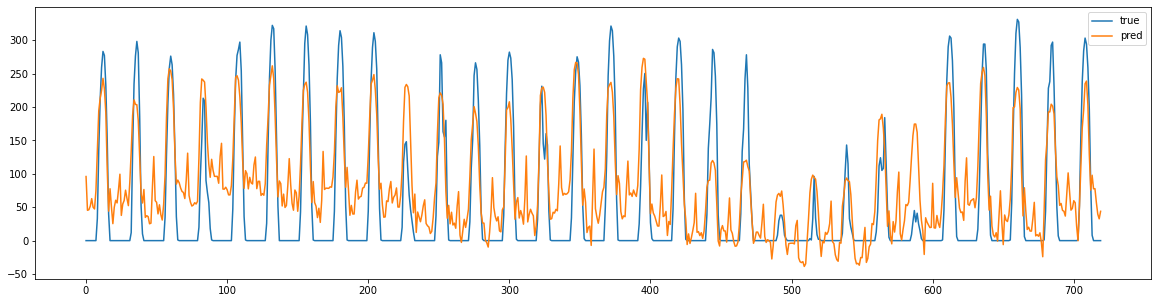

CV Score :  11.070149353191496


In [81]:
pred = ulsan_model.predict(val_x)

plt.figure(figsize=(20,5))
plt.plot(val_y, label='true')
plt.plot(pred, label='pred')
plt.legend()
plt.show()
print('CV Score : ', sola_nmae(val_y, pred))

In [54]:
def test_datast(fcst_df):
    start = '2021-02-01 00:00:00'
    end = '2021-02-28 23:00:00'
    
    start_idx = fcst_df[fcst_df['Forecast_time']==start].index[0]
    end_idx = fcst_df[fcst_df['Forecast_time']==end].index[0]
    
    test_df = fcst_df.loc[start_idx:end_idx, :].copy()
    
    test_df['date'] = test_df['Forecast_time'].str.split(' ').str[0]
    test_df['hour'] = test_df['Forecast_time'].str.split(' ').str[1].str.split(':').str[0].astype(int)
    
    test_df['year'] = test_df['date'].str.split('-').str[0].astype(int)
    test_df['month'] = test_df['date'].str.split('-').str[1].astype(int)
    test_df['day'] = test_df['date'].str.split('-').str[2].astype(int)
    
    test_df = test_df[['year', 'month', 'day', 'hour', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud']]
    
    test_x = test_df.to_numpy()
    
    return test_x

In [57]:
dangjin_test = test_datast(dj_fcst)
ulsan_test = test_datast(us_fcst)

In [59]:
dangjin_floating_pred = dangjin_floating_model.predict(dangjin_test)
dangjin_warehouse_pred = dangjin_warehouse_model.predict(dangjin_test)
dangjin_pred = dangjin_model.predict(dangjin_test)
ulsan_pred = ulsan_model.predict(ulsan_test)

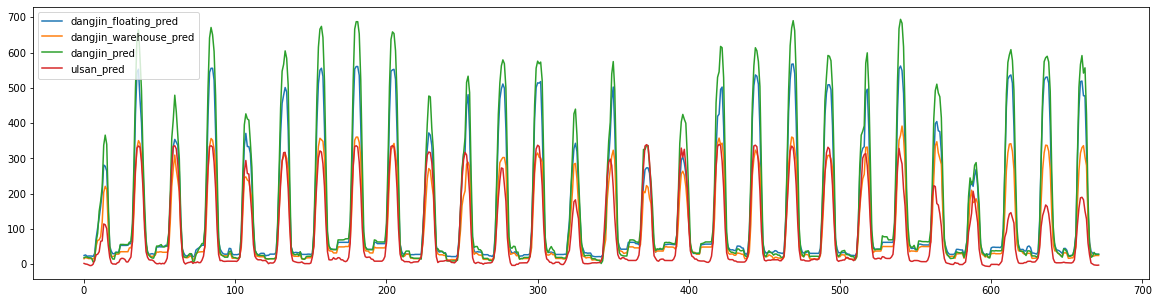

In [60]:
plt.figure(figsize=(20,5))
plt.plot(dangjin_floating_pred, label = 'dangjin_floating_pred')
plt.plot(dangjin_warehouse_pred, label = 'dangjin_warehouse_pred')
plt.plot(dangjin_pred, label = 'dangjin_pred')
plt.plot(ulsan_pred, label = 'ulsan_pred')
plt.legend()
plt.show()

In [61]:
submission = pd.read_csv('data/sample_submission.csv')
submission.head()

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
0,2021-02-01 01:00:00,0,0,0,0
1,2021-02-01 02:00:00,0,0,0,0
2,2021-02-01 03:00:00,0,0,0,0
3,2021-02-01 04:00:00,0,0,0,0
4,2021-02-01 05:00:00,0,0,0,0


In [62]:
submission.iloc[:24*28, 1] = dangjin_floating_pred
submission.iloc[:24*28, 2] = dangjin_warehouse_pred
submission.iloc[:24*28, 3] = dangjin_pred
submission.iloc[:24*28, 4] = ulsan_pred

In [63]:
submission

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
0,2021-02-01 01:00:00,24.483832,15.214285,18.105945,1.873168
1,2021-02-01 02:00:00,25.977351,18.773044,20.342899,0.174000
2,2021-02-01 03:00:00,22.270540,17.017413,20.039962,-0.375374
3,2021-02-01 04:00:00,22.867442,15.654681,17.890137,-2.402164
4,2021-02-01 05:00:00,22.867442,15.654681,17.890137,-4.250874
...,...,...,...,...,...
1387,2021-07-08 20:00:00,0.000000,0.000000,0.000000,0.000000
1388,2021-07-08 21:00:00,0.000000,0.000000,0.000000,0.000000
1389,2021-07-08 22:00:00,0.000000,0.000000,0.000000,0.000000
1390,2021-07-08 23:00:00,0.000000,0.000000,0.000000,0.000000


In [64]:
submission.to_csv('dacon_baseline.csv', index=False)